# 1 Implementation Basic Alpha Algorithm

In [2]:
from itertools import chain, combinations
from collections import Counter
from copy import deepcopy
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.petri.petrinet import PetriNet, Marking
from pm4py.objects.petri.utils import add_arc_from_to
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\pm4py\objects\petri\__init__.py:19: UserWarning: please use the pm4py.objects.petri_net package instead.
  warnings.warn('please use the pm4py.objects.petri_net package instead.')
C:\ProgramData\Anaconda3\lib\site-packages\pm4py\objects\petri\obj.py:19: UserWarning: pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.
  warnings.warn("pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.")
C:\ProgramData\Anaconda3\lib\site-packages\pm4py\objects\petri\exporter\__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.exporter package instead.
  warnings.warn('please use the pm4py.objects.petri_net.exporter package instead.')
C:\ProgramData\Anaconda3\lib\site-packages\pm4py\objects\petri\importer\__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.importer package instead.
  warnings.warn('please use the pm4py.objects.petri_net.impor

In [50]:
class AlphaMiner:
    def __init__(self, logging=False):
        self.logging=logging
        self.traces = []
                
        self.t_all = set()
        self.t_i = set()
        self.t_o = set()
        
        # footprint relations
        self.df = set() # directly follows
        self.cd = set() # causally dependent
        self.ncd = set() # not causally dependent
        self.pl = set() # parallel
        
        self.x_l = set()
        self.y_l = set()
        
        self.net = None
        self.initial_marking = None
        self.final_marking = None
        
    def apply_alpha_algorithm(self, log=None, activity_key="concept:name",dummy_log=None, log_title=None, visualize=True):
        '''Parse log and perform alpha miner steps'''
        if log is not None:
            net_name = log.strip(".xes") + "_net"
            self._parse_logfile(log,activity_key)
        elif dummy_log is not None:
            net_name = "dummy_log_net"
            self.traces = dummy_log
        else:
            raise Exception("Log is missing")
        
        # run algorithm
        self._extract_activity_sets()
        self._generate_footprint()
        self._generate_xl()
        self._generate_yl()
        
        self._create_net(net_name)
        
        if log_title:
            print(f' {log_title} '.center(60, '*'))
        
        if visualize:
            gviz = pn_visualizer.apply(self.net, self.initial_marking, self.final_marking)
            pn_visualizer.view(gviz)
    
    def _parse_logfile(self,log,activity_key):
        '''Read in log file and extract activity/event names as trace lists.'''
        l = xes_importer.apply(log)
        for trace in l:
            trace_events = []
            for event in trace:
                trace_events.append(event[activity_key])
            self.traces.append(trace_events)
        if self.logging:
            print("Finished: Log Parsing")
        
        
    def _extract_activity_sets(self):
        '''Step 1, 2, 3: Extract all, start, end activities.'''
        for trace in self.traces:
            for i, item in enumerate(trace):
                self.t_all.add(item)
                if i == 0:
                    self.t_i.add(item)
                elif i == len(trace)-1:
                    self.t_o.add(item)
        if self.logging:
            print("Finished: Activity Set Extraction")
       
    
    def _generate_footprint(self):
        # directly follows
        self._directly_follows()
        
        # extract ordering relations
        for a1 in self.t_all:
            for a2 in self.t_all:
                if (a1,a2) not in self.cd and (a1,a2) not in self.ncd and (a1,a2) not in self.pl:
                    if (a1,a2) in self.df:
                        if (a2,a1) in self.df:
                            # parallel: a1 > a2 & a2 > a1
                            self.pl.add((a1,a2))
                        else:
                            # dependent: a1 > a2 & !(a2 > a1)
                            self.cd.add((a1,a2))
                    else:
                        if (a2,a1) not in self.df:
                            # independent: !(a1 > a2) & !(a2 > a1)
                            self.ncd.add((a1,a2))
        if self.logging:
            print("Finished: Footprint Matrix")
        
        
    def _directly_follows(self):
        for t in self.traces:
            for i, a in enumerate(t):
                if i != len(t)-1:
                    self.df.add((a,t[i+1]))
    
    
    def _generate_xl(self):
        '''
         Step 4: Construct places p(A,B) such that A is set of input transitions 
        and B is set of output transitions. 
        * elements of A should not follow eachother (not causally dependent)
        * elements of B should not follow eachother (not causally dependent)
        * any of the elements in A can be followed by any of the elements in B
        '''
        # all possible event subsets
        subsets = self._subset_generation(self.t_all)
        # all subsets that are internally non causally dependent
        ncd_subsets = [s for s in subsets if self._check_set_independence(s,self.ncd)]
        for i, a in enumerate(ncd_subsets):
            for b in ncd_subsets:
                if a != b:
                    # check for causal dependency between A and B
                    if self._check_set_relation(a,b,self.cd):
                        self.x_l.add((a,b))
            print(f"Processed {i+1} of {len(ncd_subsets)+1}",end="\r")
        if self.logging:
            print("Finished: X_l Generation")
        
        
    def _subset_generation(self, activity_set):
        '''Generate all possible subsets of given set'''
        return list(chain.from_iterable(combinations(activity_set,r) for r in range(1,len(activity_set)+1)))
    
    
    def _check_set_independence(self,s,ncd):
        '''Returns True if all elements of a set are not causally dependent.'''
        for a1 in s:
            for a2 in s:
                if (a1,a2) not in ncd:
                    return False
        return True
    
    
    def _check_set_relation(self,s1,s2,cd):
        '''Check whether all elements in set 1 are causally dependent to all elements in set 2.'''
        for a1 in s1:
            for a2 in s2:
                if (a1,a2) not in cd:
                    return False
        return True
                        

    def _generate_yl(self):
        '''Remove non-maximum sets'''
        maximal_pairs = deepcopy(self.x_l)
        for s1 in self.x_l:
            for s2 in self.x_l:
                if set(s1[0]).issubset(set(s2[0])):
                    if set(s1[1]).issubset(set(s2[1])):
                        if s1[0] != s2[0]:
                            maximal_pairs.discard(s1)
                        elif s1[1] != s2[1]:
                            maximal_pairs.discard(s1)
        self.y_l = maximal_pairs
        if self.logging:
            print("Finished: Y_l Generation")
    
    
    def _create_net(self,net_name):
        
        self.net = PetriNet(net_name)
                
        # create start and end
        start = PetriNet.Place("start")
        end = PetriNet.Place("end")
        self.net.places.add(start)
        self.net.places.add(end)
        
        # add tokens
        self.initial_marking = Marking()
        self.initial_marking[start] = 1
        self.final_marking = Marking()
        self.final_marking[end] = 1
        
        # create places and transitions
        arcs = []
        transitions_created = {}
        
        for i, p_temp in enumerate(self.y_l):
            # create place
            p = PetriNet.Place(f"p_{i+1}")
            self.net.places.add(p)
            
            # create transitions
            for event_a in p_temp[0]:
                if event_a not in transitions_created.keys():
                    t_a = PetriNet.Transition(event_a, event_a)
                    self.net.transitions.add(t_a)
                    transitions_created[event_a] = t_a
                arcs.append((transitions_created[event_a],p))
                
            for event_b in p_temp[1]:
                if event_b not in transitions_created.keys():
                    t_b = PetriNet.Transition(event_b, event_b)
                    self.net.transitions.add(t_b)
                    transitions_created[event_b] = t_b
                arcs.append((p,transitions_created[event_b]))
        
        # add transitions for events that are not connected to other events
        for event in self.t_all:
            if event not in transitions_created.keys():
                t = PetriNet.Transition(event, event)
                self.net.transitions.add(t)
                transitions_created[event] = t
                    
        # add arcs from start
        for event in self.t_i:
            arcs.append((start,transitions_created[event]))
            
        # add arcs to end
        for event in self.t_o:
            arcs.append((transitions_created[event],end))
            
        # add arcs between transitions
        for a in arcs:
            add_arc_from_to(a[0],a[1],self.net)
       


Finished: Log Parsing
Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation


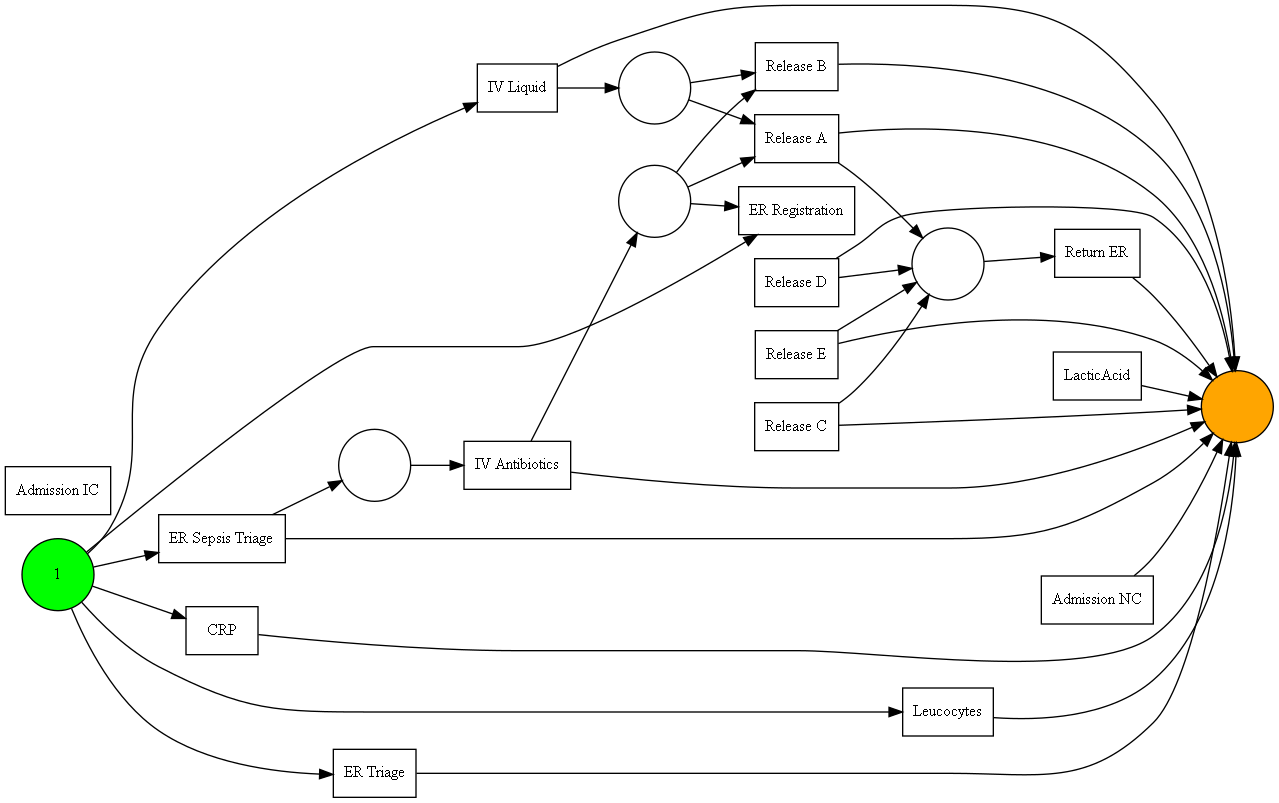

In [60]:
# create miner
am = AlphaMiner(logging=True)

"""
Below there are several manually created dummy logs (copied from the book)
to test the algorithm. They can be passed on to the function call via the
parameter 'dummy_log=dl1'.
Alternatively, a regular log file can be passed on to the function via the parameter 'log'.
"""

# dummy logs (miner can handle 1-3, but produces wrong net for log 4 (loop of one) and 5 (skip steps))
dl1 = [["a","b","c","d"],
       ["a","c","b","d"],
       ["a","e","d"]]
dl2 = [["a","c","e","g"],
       ["a","e","c","g"],
       ["b","d","f","g"],
       ["b","f","d","g"]]
dl3 = [["a","b","e","f"],
       ["a","b","e","c","d","b","f"],
       ["a","b","c","e","d","b","f"],
       ["a","b","c","d","e","b","f"],
       ["a","e","b","c","d","b","f"]]
dl4 = [["a","c"],
       ["a","b","c"],
       ["a","b","b","c"],
       ["a","b","b","b","b","c"]]
dl5 = [["a","b","c","d"],
       ["a","b","d"]]

am.apply_alpha_algorithm(log="sepsis.xes")

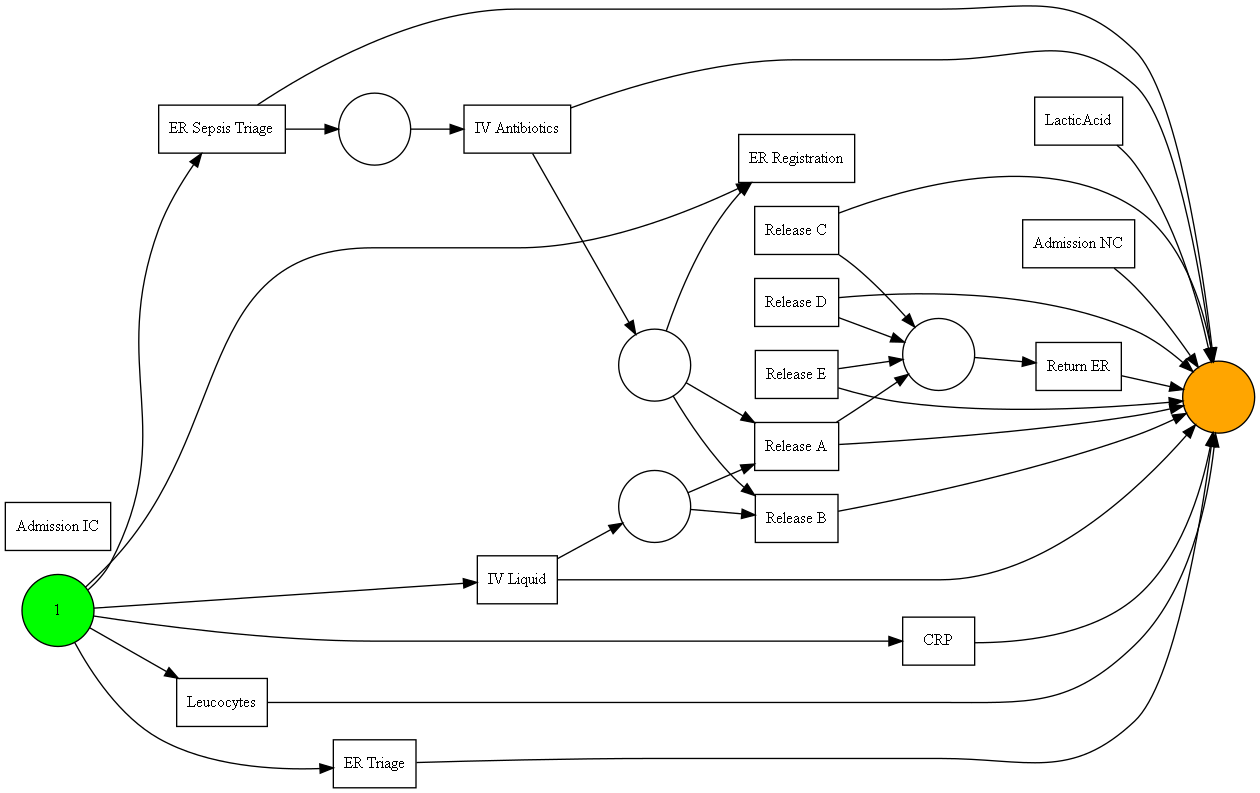

In [61]:
"""
Below, the pre-implemented pm4py AlphaMiner is applied to the same test log.
"""
log1 = xes_importer.apply("sepsis.xes")
net1, initial_marking1, final_marking1 = alpha_miner.apply(log1)

gviz1 = pn_visualizer.apply(net1, initial_marking1, final_marking1)
pn_visualizer.view(gviz1)

# 2 Implementation of Limitation Solution
## 2.1 Detect Loops

In [ ]:
# TODO

## 2.2 Detect Skip Steps
### 2.2.1 Using Footprint Matrix
#### Implementation

In [163]:
class AlphaMinerWithSkipStepsFootprintBased(AlphaMiner):
    """
    This subclass implements an improved version of the AlphaMiner base class 
    which is able to detect skip steps using the footprint matrix
    """
    
    def __init__(self, logging=False):
        super().__init__(logging)
        self.skip_involved_dependencies = [] # list of df pairs which are involved into skips
        self.skip_steps = []  # list of transitions which are skippable
        
    def apply_alpha_algorithm(self, log=None, activity_key="concept:name",dummy_log=None, log_title=None, visualize=True):
        '''Parse log and perform alpha miner steps'''
        if log is not None:
            net_name = log.strip(".xes") + "_net"
            self._parse_logfile(log,activity_key)
        elif dummy_log is not None:
            net_name = "dummy_log_net"
            self.traces = dummy_log
        else:
            raise Error("Log is missing")
        
        # run algorithm
        self._extract_activity_sets()
        self._generate_footprint()
        self._generate_xl()
        self._generate_yl()
        # difference to inherited standard apply method
        self._detect_skip_steps()
        self._modify_dependencies_for_skips()
        self._extract_activity_sets()
        
        self._create_net(net_name)
        
        if log_title:
            print(f' {log_title} '.center(60, '*'))
            
        if visualize:
            gviz = pn_visualizer.apply(self.net, self.initial_marking, self.final_marking)
            pn_visualizer.view(gviz)
                        
    def _detect_skip_steps(self):
        df_origins = [df_pair[0] for df_pair in self.df]
        # filter events which have multiple direct following events
        events_with_multiple_followers = [event for event, count in Counter(df_origins).items() if count > 1]
        
        for event in events_with_multiple_followers:
            # obtain the following events
            following_events = [event_pair[1] for event_pair in list(filter(lambda cd: cd[0] == event, self.cd))]
            
            # only when two events are following one event a skip is possible
            if len(following_events) == 2:
                following_a, following_b = following_events[0], following_events[1]
                # check if event_a is causal dependent on event_b and event_b not on event_a
                following_a, event_b = following_events[0], following_events[1]
                following_a_candidate = (following_a, following_b) in self.cd
                following_b_candidate = (following_b, following_a) in self.cd
                if (following_a_candidate and not following_b_candidate) \
                        or (following_b_candidate and not following_a_candidate):
                    self.skip_involved_dependencies.append((event, following_b))
                    self.skip_involved_dependencies.append((event, following_a))
                    
        # check which of the following events is the skippable transition
        for skip_involved_dependency in self.skip_involved_dependencies:
            if not self._check_transition_in_every_trace(skip_involved_dependency[1]):
                self.skip_steps.append(skip_involved_dependency[1])
        self.skip_steps = list(set(self.skip_steps))
        
        if self.logging:
            print("skip steps:", self.skip_steps)
            print("skip involved dependencies:", self.skip_involved_dependencies)
            print("Finished: Skip Step Detection")
            
    def _check_transition_in_every_trace(self, transition):
        """ check if a transition is containced in every trace """
        for trace in self.traces:
            if transition not in trace:
                return False
        return True     
    
    def _modify_dependencies_for_skips(self):
        """ modify causal depedency sets to deal with skip steps (inserts taus)"""
        modified_yl = deepcopy(self.y_l)
        # ensure order of processing so that tau pairs are created first 
        sorted_modified_yl = list(sorted(list(modified_yl), key=lambda x: 0 if x[1][0] in self.skip_steps else 1, reverse=False))
        tau_counter = 1
        skip_tau_pairs = {}  # dict with skip pairs of 'skip-origin: (skippable, tau)'

        for i, p_temp in enumerate(sorted_modified_yl):
            # checks for event sets which are involved in previously detected skips
            if len(p_temp[0]) == 1 and len(p_temp[1]) == 1:
                event_a, event_b = p_temp[0][0], p_temp[1][0]
                if (event_a, event_b) in self.skip_involved_dependencies:
                    # replace set with set where right set of causal dependcy includes tau in addition
                    if event_b in self.skip_steps:
                        tau = f'tau{tau_counter}'
                        skip_tau_pairs[event_a] = (event_b, tau)
                        modified_yl.add(((event_a,), (event_b, tau)))
                        tau_counter += 1
                        modified_yl.remove(p_temp)
                    # replace set with set where left set of causal dependcy includes tau in addition
                    else:
                        modified_yl.add((skip_tau_pairs[event_a], (event_b,)))
                        modified_yl.remove(p_temp)
                
        # remove causal dependency sets which contain skippable without taus
        cleaned_modified_yl = deepcopy(modified_yl)
        for p_temp in modified_yl:
            if len(p_temp[0]) == 1 and p_temp[0][0] in self.skip_steps:
                cleaned_modified_yl.remove(p_temp)
        
        # print(cleaned_modified_yl)
        self.y_l = cleaned_modified_yl

Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation
skip steps: ['f', 'c']
skip involved dependencies: [('e', 'f'), ('e', 'g'), ('b', 'c'), ('b', 'd')]
Finished: Skip Step Detection
Finished: Activity Set Extraction
*************************** Test ***************************


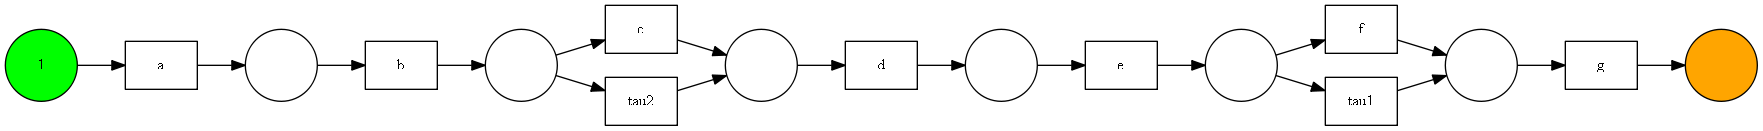

In [164]:
l_single_skip = [["a","b","d","e","g"],
   ["a","b","c","d","e","f","g"]]
#l_single_skip = [["a","b","d"],
 #        ["a","b","c","d"]]
am_skipstep_fp = AlphaMinerWithSkipStepsFootprintBased(logging=True)
am_skipstep_fp.apply_alpha_algorithm(dummy_log=l_single_skip, log_title='Test')

#### Comparison to base AlphaMiner

********************* Single Skip Step *********************


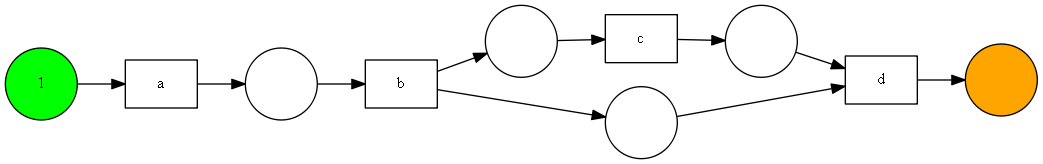

Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation
skip steps: ['c']
skip involved dependencies: [('b', 'c'), ('b', 'd')]
Finished: Skip Step Detection
********************* Single Skip Step *********************


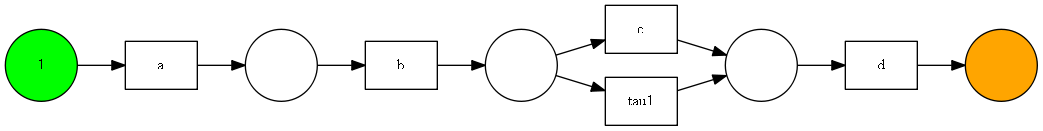

In [132]:
# trivial log with single skip step
l_single_skip = [["a","b","d"],
                 ["a","b","c","d"]]

# STANDARD ALGORITHM
am = AlphaMiner()
am.apply_alpha_algorithm(dummy_log=l_single_skip, log_title='Single Skip Step')

# IMPROVED ALGORITHM
am_skipstep_fp = AlphaMinerWithSkipStepsFootprintBased(logging=True)
am_skipstep_fp.apply_alpha_algorithm(dummy_log=l_single_skip, log_title='Single Skip Step')

#### Systematic Tests

Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation
skip steps: []
skip involved dependencies: []
Finished: Skip Step Detection
{(('a',), ('b', 'd')), (('c', 'a'), ('d',)), (('b',), ('c',))}
Finished: Activity Set Extraction
****************** Sequence of Skip Steps ******************


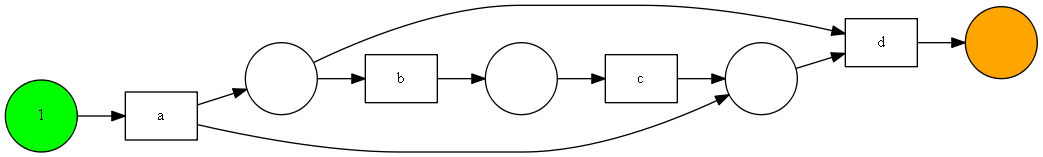

In [160]:
# not a single skip step, but a sequence of optinal steps
am = AlphaMinerWithSkipStepsFootprintBased(logging=True)
# am = AlphaMiner()
l_skip_sequence = [["a","d"],
                  ["a","b","c", "d"]]
am.apply_alpha_algorithm(dummy_log=l_skip_sequence, log_title='Sequence of Skip Steps')

# result: doesnt detect skip step/steps

Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation
skip steps: ['d']
skip involved dependencies: [('b', 'd'), ('b', 'e'), ('c', 'e'), ('c', 'd')]
Finished: Skip Step Detection
Finished: Activity Set Extraction
****************** Exclusive Split Before ******************


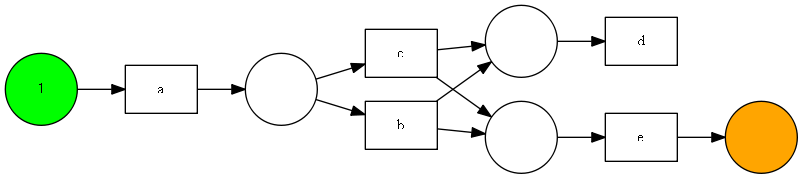

In [165]:
# exclusive split before

am = AlphaMinerWithSkipStepsFootprintBased(logging=True)  # produces a parallelism
# am = AlphaMiner()
l_exclusive_split_before = [["a","b","e"],
                            ["a","c","e",],
                            ["a","b","d","e"],
                            ["a","c","d","e",]]
am.apply_alpha_algorithm(dummy_log=l_exclusive_split_before, log_title='Exclusive Split Before')

# detects skip step but doesn't build the petri net properly

Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation
skip steps: []
skip involved dependencies: []
Finished: Skip Step Detection
Finished: Activity Set Extraction
****************** Exclusive Split After *******************


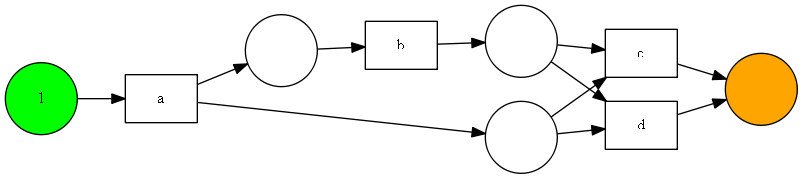

In [167]:
# exclusive split after

am = AlphaMinerWithSkipStepsFootprintBased(logging=True)
# am = AlphaMiner()
l_exclusive_split_after = [["a","b","c"],
                           ["a","b","d"],
                           ["a","c"],
                           ["a","d"]]
am.apply_alpha_algorithm(dummy_log=l_exclusive_split_after, log_title='Exclusive Split After')

# result: doesnt detect skip step

Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation
skip steps: ['d']
skip involved dependencies: [('b', 'd'), ('b', 'e'), ('c', 'e'), ('c', 'd')]
Finished: Skip Step Detection
Finished: Activity Set Extraction
******************** Concurrency Before ********************


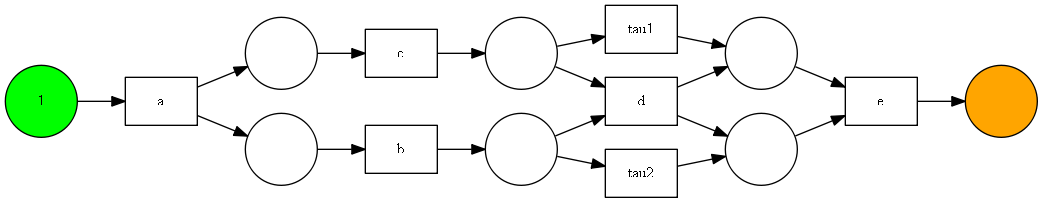

In [176]:
# concurrency before

am = AlphaMinerWithSkipStepsFootprintBased(logging=True)
# am = AlphaMiner()
l_concurrency_before = [["a","b","c","e"],
                        ["a","c","b","e"],
                        ["a","b","c","d","e"],
                        ["a","c","b","d","e"]]
am.apply_alpha_algorithm(dummy_log=l_concurrency_before, log_title='Concurrency Before')

# detects skip but concurrency join is after split -> two taus are created

Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation
skip steps: []
skip involved dependencies: []
Finished: Skip Step Detection
Finished: Activity Set Extraction
******************** Concurrency After *********************


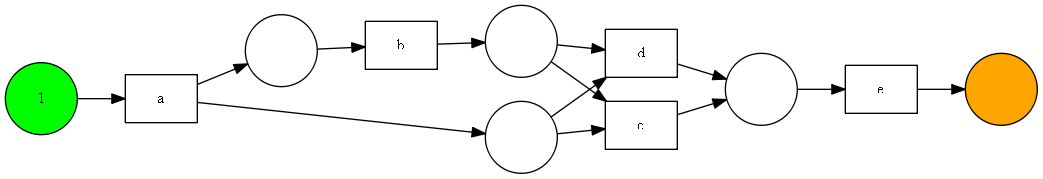

In [180]:
# concurrency after

am = AlphaMinerWithSkipStepsFootprintBased(logging=True)
# am = AlphaMiner()
l_concurrency_after = [["a","b","c","e"],
                        ["a","b","d","e"],
                        ["a","c","e"],
                        ["a","d","e"]]
am.apply_alpha_algorithm(dummy_log=l_concurrency_after, log_title='Concurrency After')

# doesn't detect skip steps

In [ ]:
# loops is not worthy to try with standard AM because it doesn't work

### 2.2.2 Using Conformance Checking

In [ ]:
class AlphaMinerWithSkipStepsConformanceBased(AlphaMiner):
    pass

## 2.3 Apply noise filtering

In [9]:
class AlphaMinerInfrequent(AlphaMiner):
    """
    This subclass implements an improved version of the AlphaMiner base class 
    which is able to filter out infrequent sequences
    """
    def __init__(self, logging=False):
        super().__init__(logging)
        self.threshold=[]
        self.traces_multiset=[]
        self.df_list=[]
        self.df_multiset=[]
        self.df_filtered=set()
        
    def apply_alpha_algorithm(self, log=None, activity_key="concept:name",dummy_log=None, log_title=None, visualize=True, threshold=0.5):
        '''Parse log and perform alpha miner steps'''
        if (threshold<0) or (threshold>=1):
            raise Exception("Noise threshold out of bounds")
        
        if log is not None:
            net_name = log.strip(".xes") + "_net"
            self._parse_logfile(log,activity_key)
        elif dummy_log is not None:
            net_name = "dummy_log_net"
            self.traces = dummy_log
        else:
            raise Exception("Log is missing")
            
        # run algorithm
        self._extract_activity_sets()
        self._directly_follows_filtered(threshold)
        self._reassess_activity_sets()
        
        self._generate_footprint()
        self._generate_xl()
        self._generate_yl()
        
        self._create_net(net_name)
        
        if log_title:
            print(f' {log_title} '.center(60, '*'))
        
        if visualize:
            gviz = pn_visualizer.apply(self.net, self.initial_marking, self.final_marking)
            pn_visualizer.view(gviz)
                
    def _directly_follows_filtered(self, threshold):
        # creating directly-follows multiset
        for t in self.traces:
            for i, a in enumerate(t):
                if i != len(t)-1:
                    self.df_list.append((a,t[i+1]))
                    
        self.df_multiset=Counter((tuple(row) for row in self.df_list))
        
        # creating a filtered set of directly-follows relations
        df_set_temp=list(self.df_multiset.keys())
        for activity in self.t_all:
            # selecting all outgoing edges
            edges_outgoing=set()
            for activity_pair in df_set_temp:
                if activity_pair[0]==activity:
                    edges_outgoing.add(activity_pair)
            
            # figuring out max frequency between the edges
            max_freq=0
            for edge in edges_outgoing:
                if self.df_multiset[edge]>max_freq:
                    max_freq=self.df_multiset[edge]
            
            # selecting only those edges that fit the threshold
            for edge in edges_outgoing:
                if self.df_multiset[edge]>max_freq*threshold:
                    self.df.add(edge)
        
        if self.logging:
            print("Finished: Directly follows generation and filtering")
        
    def _reassess_activity_sets(self):
        # After filtering out some of the directly-follows relations some of the activities may have been excluded from 
        # the log either completely, or just from the final activities list. This method checks if that is indeed so and
        # modifies t_all and t_o accordingly
        
        # t_all
        hey_all=len(self.t_all)
        t_all_new=set()
        for activity in self.t_all:
            for edge in self.df:
                if activity in edge:
                    t_all_new.add(activity)
        self.t_all=t_all_new
        ho_all=len(self.t_all)
        
        #t_o
        hey_o=len(self.t_o)
        t_o_new=set()
        tempset=set()
        for activity in self.t_o:
            for trace in self.traces:
                if trace[len(trace)-1]==activity:
                    tempset.add((trace[len(trace)-2],trace[len(trace)-1]))
            flag=False
            for edge in tempset:
                if edge in self.df:
                    flag=True
                    break
            if flag:
                t_o_new.add(activity)
        self.t_o=t_o_new
        ho_o=len(self.t_o)
        
        if self.logging:
            print("Finished: activity sets reassessment. Removed: ",hey_all-ho_all," from t_all and ",hey_o-ho_o," from t_o")
    
    def _generate_footprint(self):
        # extract ordering relations
        for a1 in self.t_all:
            for a2 in self.t_all:
                if (a1,a2) not in self.cd and (a1,a2) not in self.ncd and (a1,a2) not in self.pl:
                    if (a1,a2) in self.df:
                        if (a2,a1) in self.df:
                            # parallel: a1 > a2 & a2 > a1
                            self.pl.add((a1,a2))
                        else:
                            # dependent: a1 > a2 & !(a2 > a1)
                            self.cd.add((a1,a2))
                    else:
                        if (a2,a1) not in self.df:
                            # independent: !(a1 > a2) & !(a2 > a1)
                            self.ncd.add((a1,a2))
        if self.logging:
            print("Finished: Footprint Matrix")
        
        
    def _directly_follows(self):
        # directly follows relations
        for t in self.traces:
            for i, a in enumerate(t):
                if i != len(t)-1:
                    self.df.add((a,t[i+1]))
                    
        if self.logging:
            print("Finished: Directly follows")
        


Finished: Log Parsing
Finished: Activity Set Extraction
Finished: Directly follows generation and filtering
Finished: activity sets reassessment. Removed:  0  from t_all and  1  from t_o
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation


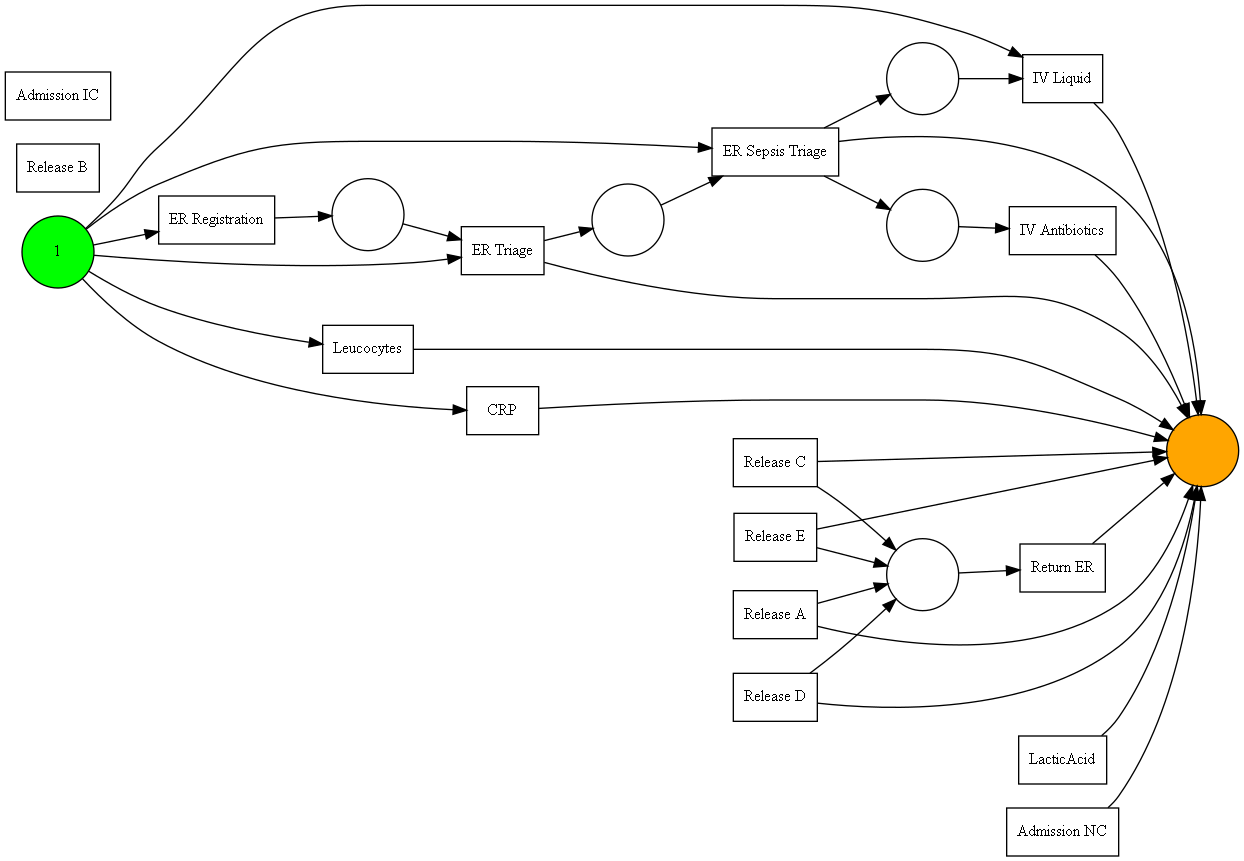

In [18]:
# applying AM-Infrequent to sepsis.xes at 10% noise reduction yields a more streamlined, clean process.
ami = AlphaMinerInfrequent(logging=True)
ami.apply_alpha_algorithm(log="sepsis.xes",threshold=0.1)

In [82]:
class AlphaMinerCombined():
    """
    This class implements alpha algorithm and our modifications to it.
    Set of modifications to apply can be chosen using set of flags.
    """
    def __init__(self, logging=False, 
                 flagModification=False, 
                 flagSkipsFootprint=False, 
                 flagSkipsConformance=False):
        
        #base algo properties:
        self.logging=logging
        self.net_name=""
        self.traces = []       
        self.t_all = set()
        self.t_i = set()
        self.t_o = set()
        # footprint relations
        self.df = set() # directly follows
        self.cd = set() # causally dependent
        self.ncd = set() # not causally dependent
        self.pl = set() # parallel
        self.x_l = set()
        self.y_l = set()
        self.net = None
        self.initial_marking = None
        self.final_marking = None
                
        # properties for noise filtering:
        self.threshold=[]
        self.traces_multiset=[]
        self.df_list=[]
        self.df_multiset=[]
        self.df_filtered=set()
        
        # properties for footprint based skip detection:
        self.skip_involved_dependencies = [] # list of df pairs which are involved into skips
        self.skip_steps = []  # list of transitions which are skippable
        
        # Setting up the flags for each of the improvements. This is done here in constructor to force re-initialization 
        # of the class for execution of new method combinations. Re-initialization is needed to clean class properties.
        self.flagModification=flagModification
        self.flagSkipsFootprint=flagSkipsFootprint
        self.flagSkipsConformance=flagSkipsConformance
        
        # checking for the allowed cases:
        if not ((self.flagModification==False) and (self.flagSkipsFootprint==False) and (self.flagSkipsConformance==False) or
               (self.flagModification==True) and (self.flagSkipsFootprint==True) and (self.flagSkipsConformance==False) or
               (self.flagModification==True) and (self.flagSkipsFootprint==False) and (self.flagSkipsConformance==True)):
                 raise Exception("Flag combination not allowed. Allowed combinations: FFF, TFT, TTF")
        
    def apply_our_algorithm(self, log=None, activity_key="concept:name",dummy_log=None, log_title=None, visualize=True, threshold=0.9):
        # three cases exist:
        # apply base algorithm
        # apply noise filtering, footprint-based skips detection, and loop detection
        # apply noise filtering, conformance-based skips detection, and loop detection
        
        # Case 1: base algo:
        if self.flagModification==False:
            
            self._read_log(log, activity_key, dummy_log)
            self._extract_activity_sets()
            self._directly_follows()
            self._generate_footprint()
            self._generate_xl()
            self._generate_yl()
            self._create_net(self.net_name)
        
            if log_title:
                print(f' {log_title} '.center(60, '*'))

            if visualize:
                gviz = pn_visualizer.apply(self.net, self.initial_marking, self.final_marking)
                pn_visualizer.view(gviz)
        
        # Case 2: footprint-based skips:
        # MODIFY THIS
        elif self.flagSkipsFootprint==True:
            
            self._read_log(log, activity_key, dummy_log)
            self._check_threshold_bounds(threshold) # for noise filtering
            self._extract_activity_sets()
            self._directly_follows_filtered(threshold) # for noise filtering
            self._reassess_activity_sets() # for noise filtering
            self._generate_footprint()
            self._generate_xl()
            self._generate_yl()
            # difference to inherited standard apply method
            self._detect_skip_steps()
            self._modify_dependencies_for_skips()
            self._extract_activity_sets()
            
            self._create_net(self.net_name)

            if log_title:
                print(f' {log_title} '.center(60, '*'))

            if visualize:
                gviz = pn_visualizer.apply(self.net, self.initial_marking, self.final_marking)
                pn_visualizer.view(gviz)
        
        # Case 3: conformance-based skips:
        # MODIFY THIS
        elif self.flagSkipsConformance==True:
            
            self._read_log(log, activity_key, dummy_log)
            self._check_threshold_bounds(threshold) # for noise filtering
            self._extract_activity_sets()
            self._directly_follows_filtered(threshold) # for noise filtering
            self._reassess_activity_sets() # for noise filtering
            self._generate_footprint()
            self._generate_xl()
            self._generate_yl()
            self._create_net(self.net_name)

            if log_title:
                print(f' {log_title} '.center(60, '*'))

            if visualize:
                gviz = pn_visualizer.apply(self.net, self.initial_marking, self.final_marking)
                pn_visualizer.view(gviz)
                
    def _read_log(self, log, activity_key, dummy_log):
        if log is not None:
            self.net_name = log.strip(".xes") + "_net"
            self._parse_logfile(log,activity_key)
        elif dummy_log is not None:
            self.net_name = "dummy_log_net"
            self.traces = dummy_log
        else:
            raise Exception("Log is missing")
    
    def _generate_footprint(self):
        # extract ordering relations
        for a1 in self.t_all:
            for a2 in self.t_all:
                if (a1,a2) not in self.cd and (a1,a2) not in self.ncd and (a1,a2) not in self.pl:
                    if (a1,a2) in self.df:
                        if (a2,a1) in self.df:
                            # parallel: a1 > a2 & a2 > a1
                            self.pl.add((a1,a2))
                        else:
                            # dependent: a1 > a2 & !(a2 > a1)
                            self.cd.add((a1,a2))
                    else:
                        if (a2,a1) not in self.df:
                            # independent: !(a1 > a2) & !(a2 > a1)
                            self.ncd.add((a1,a2))
        if self.logging:
            print("Finished: Footprint Matrix")
            
    def _parse_logfile(self,log,activity_key):
        '''Read in log file and extract activity/event names as trace lists.'''
        l = xes_importer.apply(log)
        for trace in l:
            trace_events = []
            for event in trace:
                trace_events.append(event[activity_key])
            self.traces.append(trace_events)
        if self.logging:
            print("Finished: Log Parsing")
        
        
    def _extract_activity_sets(self):
        '''Step 1, 2, 3: Extract all, start, end activities.'''
        for trace in self.traces:
            for i, item in enumerate(trace):
                self.t_all.add(item)
                if i == 0:
                    self.t_i.add(item)
                elif i == len(trace)-1:
                    self.t_o.add(item)
        if self.logging:
            print("Finished: Activity Set Extraction")
            
    def _directly_follows(self):
        for t in self.traces:
            for i, a in enumerate(t):
                if i != len(t)-1:
                    self.df.add((a,t[i+1]))
    
    
    def _generate_xl(self):
        '''
         Step 4: Construct places p(A,B) such that A is set of input transitions 
        and B is set of output transitions. 
        * elements of A should not follow eachother (not causally dependent)
        * elements of B should not follow eachother (not causally dependent)
        * any of the elements in A can be followed by any of the elements in B
        '''
        # all possible event subsets
        subsets = self._subset_generation(self.t_all)
        # all subsets that are internally non causally dependent
        ncd_subsets = [s for s in subsets if self._check_set_independence(s,self.ncd)]
        for i, a in enumerate(ncd_subsets):
            for b in ncd_subsets:
                if a != b:
                    # check for causal dependency between A and B
                    if self._check_set_relation(a,b,self.cd):
                        self.x_l.add((a,b))
            print(f"Processed {i+1} of {len(ncd_subsets)+1}",end="\r")
        if self.logging:
            print("Finished: X_l Generation")
        
        
    def _subset_generation(self, activity_set):
        '''Generate all possible subsets of given set'''
        return list(chain.from_iterable(combinations(activity_set,r) for r in range(1,len(activity_set)+1)))
    
    
    def _check_set_independence(self,s,ncd):
        '''Returns True if all elements of a set are not causally dependent.'''
        for a1 in s:
            for a2 in s:
                if (a1,a2) not in ncd:
                    return False
        return True
    
    
    def _check_set_relation(self,s1,s2,cd):
        '''Check whether all elements in set 1 are causally dependent to all elements in set 2.'''
        for a1 in s1:
            for a2 in s2:
                if (a1,a2) not in cd:
                    return False
        return True
                        

    def _generate_yl(self):
        '''Remove non-maximum sets'''
        maximal_pairs = deepcopy(self.x_l)
        for s1 in self.x_l:
            for s2 in self.x_l:
                if set(s1[0]).issubset(set(s2[0])):
                    if set(s1[1]).issubset(set(s2[1])):
                        if s1[0] != s2[0]:
                            maximal_pairs.discard(s1)
                        elif s1[1] != s2[1]:
                            maximal_pairs.discard(s1)
        self.y_l = maximal_pairs
        if self.logging:
            print("Finished: Y_l Generation")
    
    
    def _create_net(self,net_name):
        
        self.net = PetriNet(net_name)
                
        # create start and end
        start = PetriNet.Place("start")
        end = PetriNet.Place("end")
        self.net.places.add(start)
        self.net.places.add(end)
        
        # add tokens
        self.initial_marking = Marking()
        self.initial_marking[start] = 1
        self.final_marking = Marking()
        self.final_marking[end] = 1
        
        # create places and transitions
        arcs = []
        transitions_created = {}
        
        for i, p_temp in enumerate(self.y_l):
            # create place
            p = PetriNet.Place(f"p_{i+1}")
            self.net.places.add(p)
            
            # create transitions
            for event_a in p_temp[0]:
                if event_a not in transitions_created.keys():
                    t_a = PetriNet.Transition(event_a, event_a)
                    self.net.transitions.add(t_a)
                    transitions_created[event_a] = t_a
                arcs.append((transitions_created[event_a],p))
                
            for event_b in p_temp[1]:
                if event_b not in transitions_created.keys():
                    t_b = PetriNet.Transition(event_b, event_b)
                    self.net.transitions.add(t_b)
                    transitions_created[event_b] = t_b
                arcs.append((p,transitions_created[event_b]))
        
        # add transitions for events that are not connected to other events
        for event in self.t_all:
            if event not in transitions_created.keys():
                t = PetriNet.Transition(event, event)
                self.net.transitions.add(t)
                transitions_created[event] = t
                    
        # add arcs from start
        for event in self.t_i:
            arcs.append((start,transitions_created[event]))
            
        # add arcs to end
        for event in self.t_o:
            arcs.append((transitions_created[event],end))
            
        # add arcs between transitions
        for a in arcs:
            add_arc_from_to(a[0],a[1],self.net)
    
    def _check_threshold_bounds(self, threshold): # for noise filtering
        if (threshold<0) or (threshold>=1):
            raise Exception("Noise threshold out of bounds")
            
    # FOR NOISE FILTERING
    
    def _directly_follows_filtered(self, threshold): 
        # creating directly-follows multiset
        for t in self.traces:
            for i, a in enumerate(t):
                if i != len(t)-1:
                    self.df_list.append((a,t[i+1]))
                    
        self.df_multiset=Counter((tuple(row) for row in self.df_list))
        
        # creating a filtered set of directly-follows relations
        df_set_temp=list(self.df_multiset.keys())
        for activity in self.t_all:
            # selecting all outgoing edges
            edges_outgoing=set()
            for activity_pair in df_set_temp:
                if activity_pair[0]==activity:
                    edges_outgoing.add(activity_pair)
            
            # figuring out max frequency between the edges
            max_freq=0
            for edge in edges_outgoing:
                if self.df_multiset[edge]>max_freq:
                    max_freq=self.df_multiset[edge]
            
            # selecting only those edges that fit the threshold
            for edge in edges_outgoing:
                if self.df_multiset[edge]>max_freq*threshold:
                    self.df.add(edge)
        
        if self.logging:
            print("Finished: Directly follows generation and filtering")
    
    def _reassess_activity_sets(self): # for noise filtering
        # After filtering out some of the directly-follows relations some of the activities may have been excluded from 
        # the log either completely, or just from the final activities list. This method checks if that is indeed so and
        # modifies t_all and t_o accordingly
        
        # t_all
        hey_all=len(self.t_all)
        t_all_new=set()
        for activity in self.t_all:
            for edge in self.df:
                if activity in edge:
                    t_all_new.add(activity)
        self.t_all=t_all_new
        ho_all=len(self.t_all)
        
        #t_o
        hey_o=len(self.t_o)
        t_o_new=set()
        tempset=set()
        for activity in self.t_o:
            for trace in self.traces:
                if trace[len(trace)-1]==activity:
                    tempset.add((trace[len(trace)-2],trace[len(trace)-1]))
            flag=False
            for edge in tempset:
                if edge in self.df:
                    flag=True
                    break
            if flag:
                t_o_new.add(activity)
        self.t_o=t_o_new
        ho_o=len(self.t_o)
        
        if self.logging:
            print("Finished: activity sets reassessment. Removed: ",hey_all-ho_all," from t_all and ",hey_o-ho_o," from t_o")
    
    # FOR FOOTPRINT BASED SKIP STEP DETECTION
    
    def _detect_skip_steps_footprint_based(self):
        df_origins = [df_pair[0] for df_pair in self.df]
        # filter events which have multiple direct following events
        events_with_multiple_followers = [event for event, count in Counter(df_origins).items() if count > 1]
        
        for event in events_with_multiple_followers:
            # obtain the following events
            following_events = [event_pair[1] for event_pair in list(filter(lambda cd: cd[0] == event, self.cd))]
            
            # only when two events are following one event a skip is possible
            if len(following_events) == 2:
                following_a, following_b = following_events[0], following_events[1]
                # check if event_a is causal dependent on event_b and event_b not on event_a
                following_a, event_b = following_events[0], following_events[1]
                following_a_candidate = (following_a, following_b) in self.cd
                following_b_candidate = (following_b, following_a) in self.cd
                if (following_a_candidate and not following_b_candidate) \
                        or (following_b_candidate and not following_a_candidate):
                    self.skip_involved_dependencies.append((event, following_b))
                    self.skip_involved_dependencies.append((event, following_a))
                    
        # check which of the following events is the skippable transition
        for skip_involved_dependency in self.skip_involved_dependencies:
            if not self._check_transition_in_every_trace(skip_involved_dependency[1]):
                self.skip_steps.append(skip_involved_dependency[1])
        self.skip_steps = list(set(self.skip_steps))
        
        if self.logging:
            print("skip steps:", self.skip_steps)
            print("skip involved dependencies:", self.skip_involved_dependencies)
            print("Finished: Skip Step Detection")
            
    def _check_transition_in_every_trace(self, transition):
        """ check if a transition is containced in every trace """
        for trace in self.traces:
            if transition not in trace:
                return False
        return True     
    
    def _modify_dependencies_for_footprint_skips(self):
        """ modify causal depedency sets to deal with skip steps (inserts taus)"""
        modified_yl = deepcopy(self.y_l)
        # ensure order of processing so that tau pairs are created first 
        sorted_modified_yl = list(sorted(list(modified_yl), key=lambda x: 0 if x[1][0] in self.skip_steps else 1, reverse=False))
        tau_counter = 1
        skip_tau_pairs = {}  # dict with skip pairs of 'skip-origin: (skippable, tau)'

        for i, p_temp in enumerate(sorted_modified_yl):
            # checks for event sets which are involved in previously detected skips
            if len(p_temp[0]) == 1 and len(p_temp[1]) == 1:
                event_a, event_b = p_temp[0][0], p_temp[1][0]
                if (event_a, event_b) in self.skip_involved_dependencies:
                    # replace set with set where right set of causal dependcy includes tau in addition
                    if event_b in self.skip_steps:
                        tau = f'tau{tau_counter}'
                        skip_tau_pairs[event_a] = (event_b, tau)
                        modified_yl.add(((event_a,), (event_b, tau)))
                        tau_counter += 1
                        modified_yl.remove(p_temp)
                    # replace set with set where left set of causal dependcy includes tau in addition
                    else:
                        modified_yl.add((skip_tau_pairs[event_a], (event_b,)))
                        modified_yl.remove(p_temp)
                
        # remove causal dependency sets which contain skippable without taus
        cleaned_modified_yl = deepcopy(modified_yl)
        for p_temp in modified_yl:
            if len(p_temp[0]) == 1 and p_temp[0][0] in self.skip_steps:
                cleaned_modified_yl.remove(p_temp)
        
        # print(cleaned_modified_yl)
        self.y_l = cleaned_modified_yl
        
    # FOR CONFORMANCE BASED SKIP DETECTION
    # todo: @Guszti add here
    
    # FOR LOOP DETECTION
    # todo: @Kai & Laura add here
    


Finished: Log Parsing
Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation


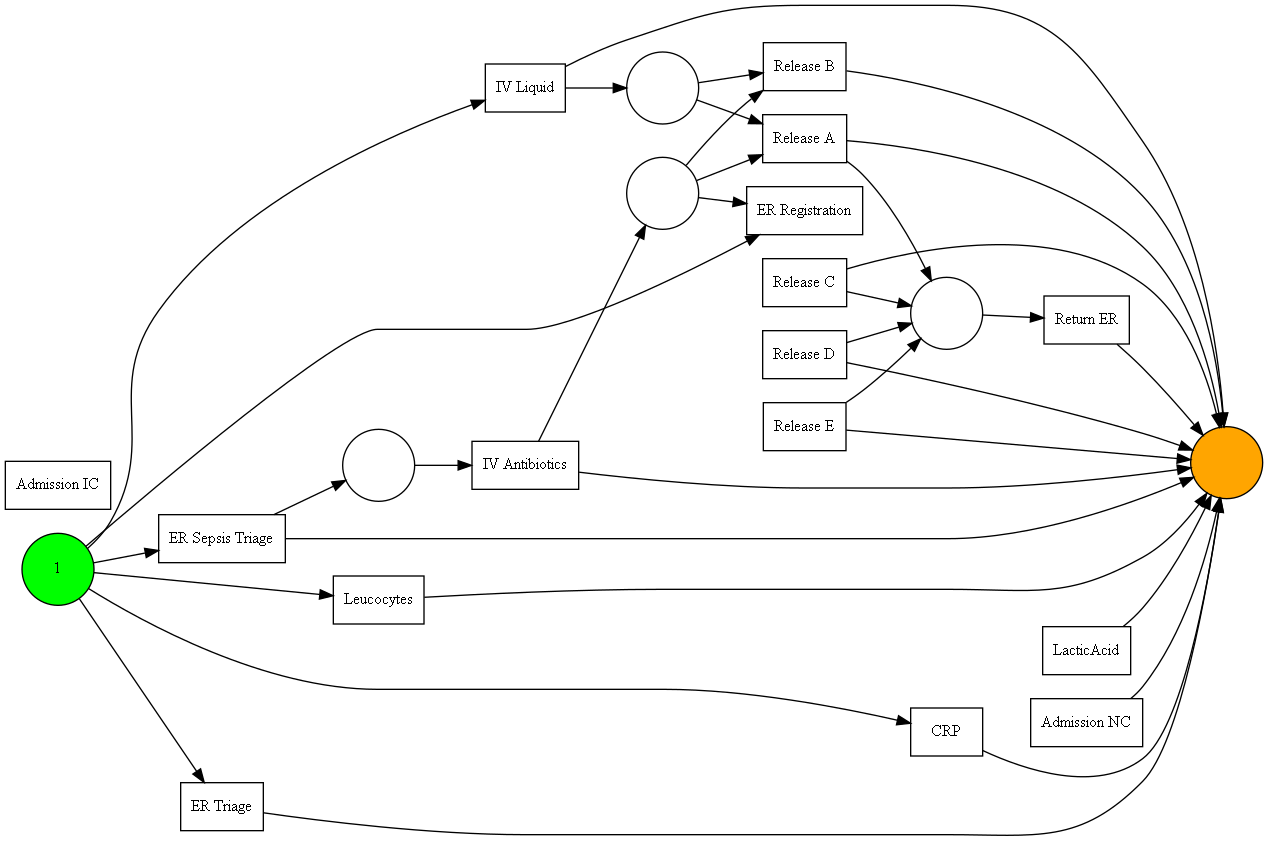

In [85]:
# Examples
# Running base algorithm:
amc=AlphaMinerCombined(logging=True)
amc.apply_our_algorithm(log="sepsis.xes")


Finished: Log Parsing
Finished: Activity Set Extraction
Finished: Directly follows generation and filtering
Finished: activity sets reassessment. Removed:  0  from t_all and  4  from t_o
Finished: Footprint Matrix
Processed 634 of 3288Finished: X_l Generation
Finished: Y_l Generation


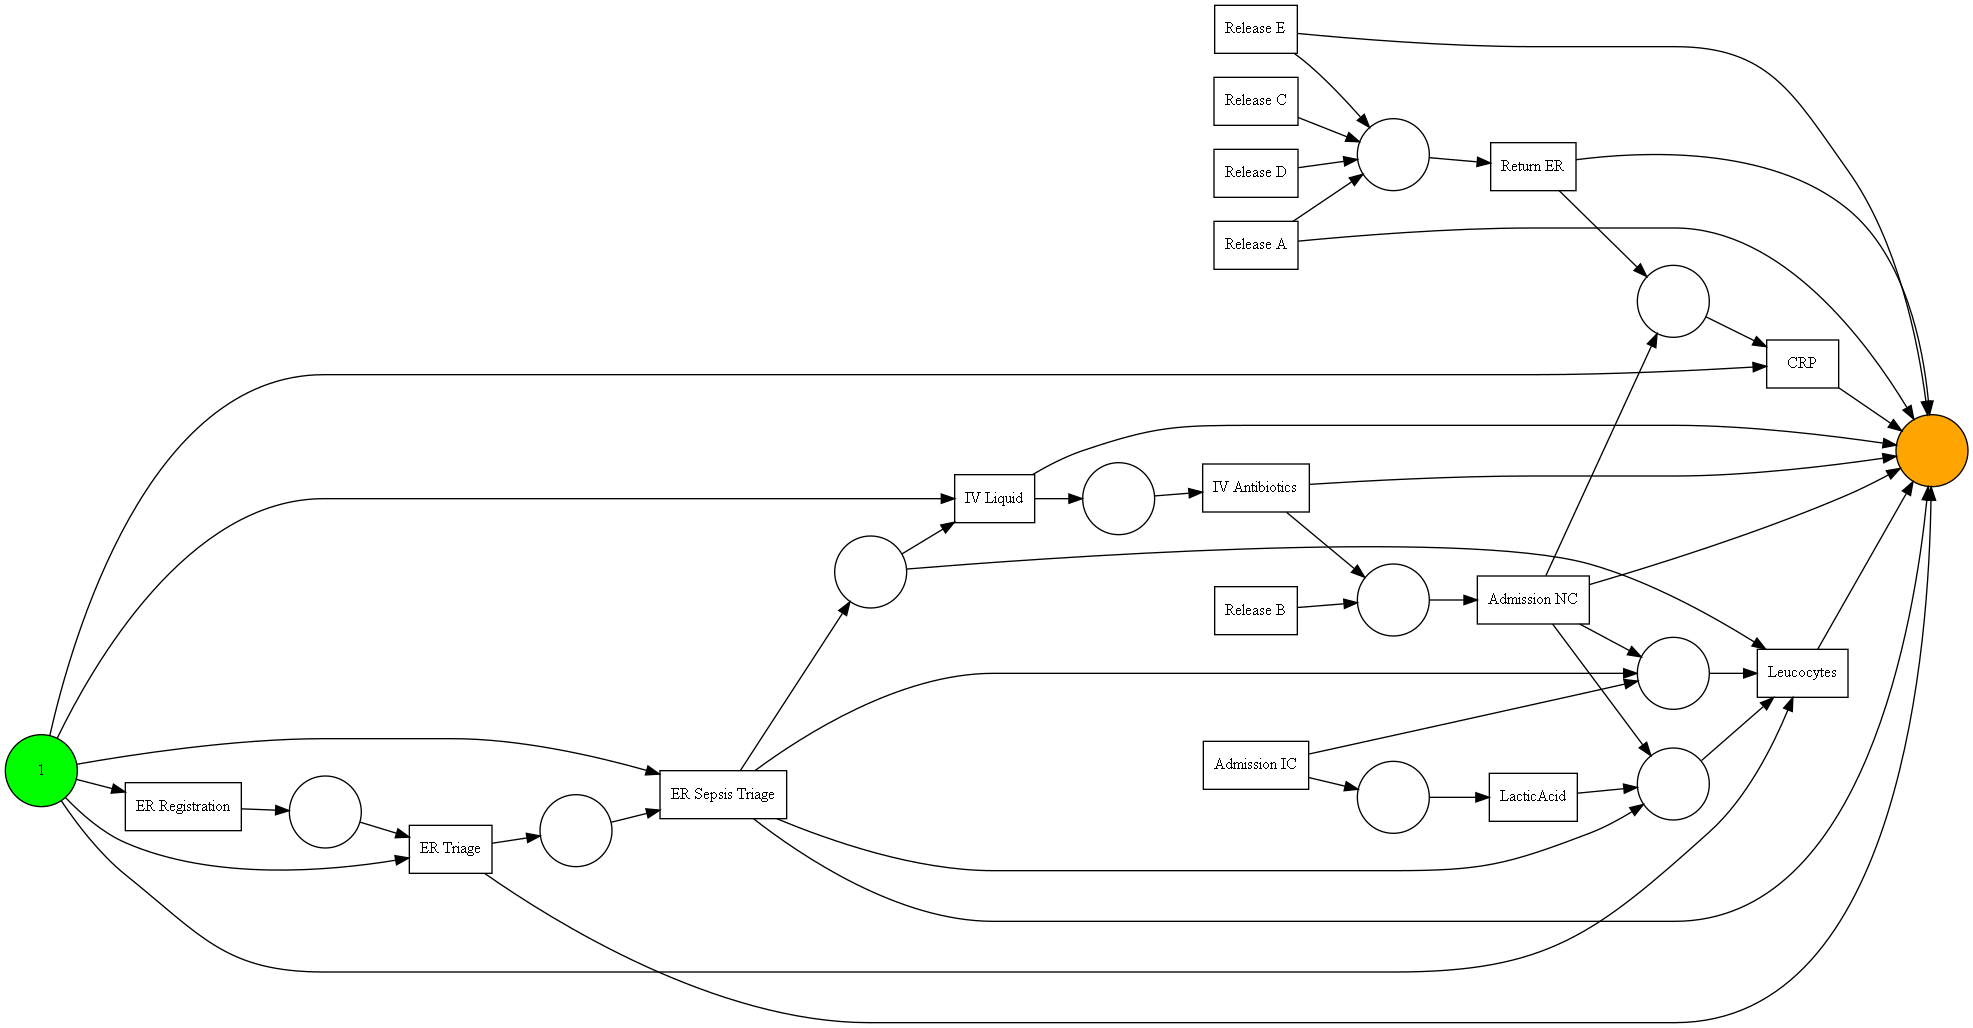

In [83]:
# running modified algorithm with footprint-based skips generation
amc=AlphaMinerCombined(logging=True, flagModification=True, flagSkipsFootprint=True)
amc.apply_our_algorithm(log="sepsis.xes")


Finished: Log Parsing
Finished: Activity Set Extraction
Finished: Directly follows generation and filtering
Finished: activity sets reassessment. Removed:  0  from t_all and  4  from t_o
Finished: Footprint Matrix
Processed 980 of 3288Finished: X_l Generation
Finished: Y_l Generation


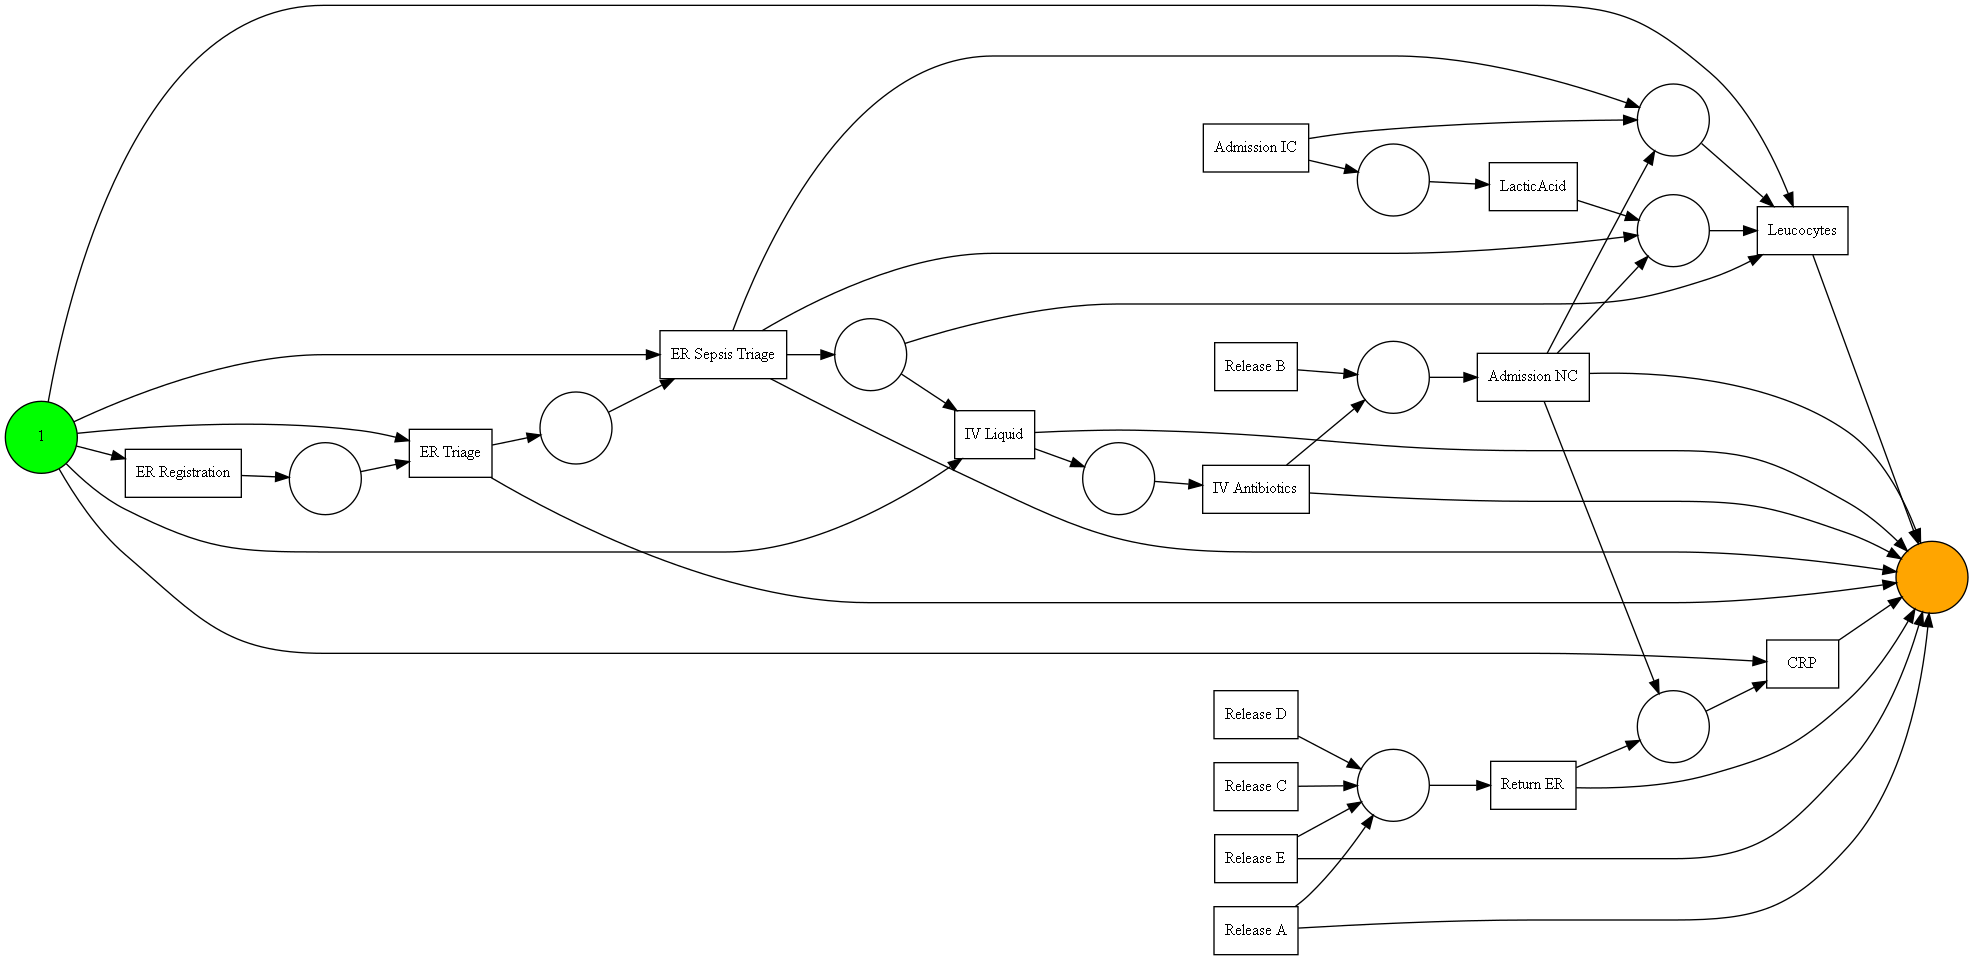

In [86]:
# running modified algorithm with conformance-based skips generation
amc=AlphaMinerCombined(logging=True, flagModification=True, flagSkipsConformance=True)
amc.apply_our_algorithm(log="sepsis.xes")